# Examples of XAI-Lib Usage for image data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

## Intgrad

In [2]:
import tensorflow as tf
assert tf.__version__[0]=='2', 'please install tensorflow 2.x'

# Load Dataset
from tensorflow.keras.datasets import mnist
(MNIST_x_data_train, MNIST_y_data_train), (MNIST_x_data_test, MNIST_y_data_test) = mnist.load_data()

# Load the model
MNIST_CNN = tf.keras.models.load_model('./models/cnn_simple_mnist_no_pickle')
MNIST_CNN.trainable=False
MNIST_CNN.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)              

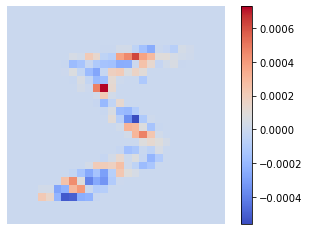

In [3]:
from xailib.explainers.intgrad_explainer import IntgradImageExplainer

# 1) Create the Explainer
ig = IntgradImageExplainer(MNIST_CNN)

# 2) Fit the Explainer
ig.fit(1,'black')

# 3) Explain an Instance
image = MNIST_x_data_train[0,:].reshape(28,28,1)
scores = ig.explain(image)

plt.imshow(scores,cmap='coolwarm')
plt.colorbar()
plt.axis('off');

## LIME

In [4]:
# Load data
imagenet_x_data = pickle.load(open('./datasets/imagenet.p','rb'))
imagenet_y_data = pickle.load(open('./datasets/imagenet_labels.p','rb'))
imagenet_map = pickle.load(open('./datasets/imagenet_mapping_labels.p','rb'))

# Load Model
imagenet_VGG = tf.keras.applications.VGG16(input_shape=(224,224,3),include_top=True,weights='imagenet')
imagenet_VGG.trainable = False
imagenet_VGG.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

  0%|          | 0/500 [00:00<?, ?it/s]

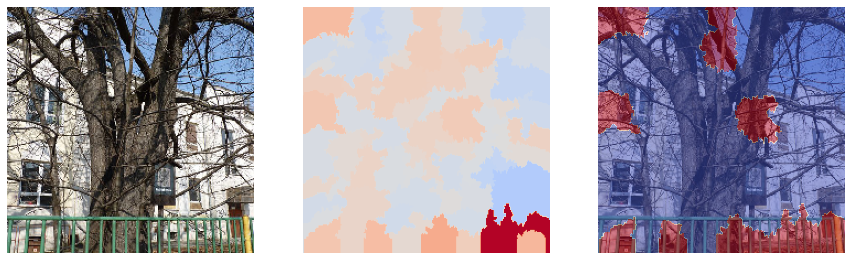

In [5]:
from xailib.explainers.lime_explainer import LimeXAIImageExplainer
from skimage.color import label2rgb

F, ax = plt.subplots(1,3,figsize=(15,5))
idx = 0

# 1) Create the Explainer
lm = LimeXAIImageExplainer(imagenet_VGG)

# 2) Fit the Explainer
lm.fit()

# 3) Explain an Instance
explanation = lm.explain(imagenet_x_data[idx], num_samples=500)

ax[0].imshow(imagenet_x_data[idx].astype(int))
ax[0].axis('off')

#plot heatmap
ind =  explanation.top_labels[0]
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 
ax[1].imshow(heatmap, cmap = 'coolwarm', vmin  = -heatmap.max(), vmax = heatmap.max())
ax[1].axis('off')

#plot overlap
temp, mask = explanation.get_image_and_mask(np.argmax(imagenet_VGG.predict(imagenet_x_data[idx:idx+1])), 
                                            positive_only=True, 
                                            num_features=10, 
                                            hide_rest=False, 
                                            min_weight = 0.01)

ax[2].imshow(imagenet_x_data[idx].astype(int))
ax[2].imshow(mask,alpha=0.5,cmap='coolwarm')
ax[2].axis('off');

# ABELE

In [2]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

### 1) Autoencoder Training

In [2]:
import sys
import os
from externals.ABELE.experiments.exputil import get_autoencoder
from externals.ABELE.experiments.exputil import get_dataset
import shap
import warnings
warnings.filterwarnings('ignore')

#select the dataset: cifar10, net (imagenet) or mnist
dataset = 'mnist'
ae_name = 'aae'
#define the epochs and the batch size
epochs = 2000
batch_size = 64
#Print training summary every sample_interval step
sample_interval = 50
#get the dataset and train the autoencoder
path = './'
path_aemodels = path + 'models/abele/%s/%s/' % (dataset,ae_name)
if not os.path.exists(path_aemodels):
    os.makedirs(path_aemodels)
#os.system('mkdir '+path_aemodels)
_, _, X_test, Y_test, use_rgb = get_dataset(dataset)
print(X_test.shape)
print(Y_test.shape)
ae = get_autoencoder(X_test, ae_name, dataset, path_aemodels)
print(ae)
ae.fit(X_test, epochs=epochs, batch_size=batch_size, sample_interval=sample_interval)
ae.save_model()
ae.sample_images(epochs)

(10000, 28, 28, 3)
(10000,)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              5120      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 530,433
Trainable params: 530,433
Non-trainable params: 0
_________________________________________________________________
Model: "model_1"
_______________________________________________________________________

./models/abele/mnist/aae/
mnist
generating neighborhood - hrg
gen	nevals	avg     	min     	max     
0  	75    	0.496654	0.496654	0.496654
1  	48    	0.537897	0.0579769	0.993306
2  	53    	0.627871	0.119653 	0.993136
3  	34    	0.790076	0.00748103	0.993301
4  	43    	0.9199  	0.440866  	0.993301
5  	55    	0.925726	0.0092435 	0.993301
6  	28    	0.943659	0.00938515	0.993301
7  	37    	0.915249	0.00985549	0.993301
8  	46    	0.965306	0.439844  	0.993301
9  	46    	0.928569	0.00967004	0.993301
10 	40    	0.930085	0.235142  	0.993301
11 	46    	0.960196	0.00793419	0.993301
12 	43    	0.942245	0.0145741 	0.993301
13 	42    	0.964124	0.387819  	0.993301
14 	44    	0.950406	0.012175  	0.993301
15 	42    	0.915155	0.00932481	0.993301
16 	42    	0.939919	0.0347778 	0.993301
17 	46    	0.944614	0.00982405	0.993301
18 	52    	0.939351	0.010029  	0.993301
19 	45    	0.935905	0.00903004	0.993301
20 	42    	0.953593	0.0233971 	0.993301
21 	44    	0.965068	0.0160861 	0.993302
22 	39    	0.993196	0.98

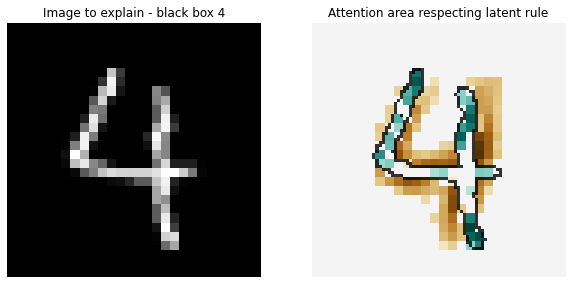

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time
from skimage.color import gray2rgb, rgb2gray
from skimage import feature, transform

from externals.ABELE.ilore.ilorem import ILOREM
from externals.ABELE.ilore.util import neuclidean

from externals.ABELE.experiments.exputil import get_dataset
from externals.ABELE.experiments.exputil import get_autoencoder

import warnings
warnings.filterwarnings('ignore')

random_state = 0
dataset = 'mnist'
black_box = 'AB' #agnostic Black Box

# load autoencoder and black box
ae_name = 'aae'
path = './'
path_aemodels = path + 'models/abele/%s/%s/' % (dataset,ae_name)
bb = tf.keras.models.load_model("./models/cnn_simple_mnist_no_pickle")
# defining two functions for bb, one to return probability values and the other one with only the index value
def bb_predict_proba(X):
    X = X.astype(float)
    X = rgb2gray(X).reshape(-1,28,28,1)
    Y = bb.predict(X)   
    return Y
def bb_predict(X):
    X = X.astype(float)
    X = rgb2gray(X).reshape(-1,28,28,1)
    Y = bb.predict(X)   
    return np.argmax(Y, axis=1)
# load data
_, _, X_test, Y_test, use_rgb = get_dataset(dataset)
print(path_aemodels)
print(dataset)
# load auto encoder
ae = get_autoencoder(X_test, ae_name, dataset, path_aemodels)
ae.load_model()

class_name = 'class'
class_values = ['%s' % i for i in range(len(np.unique(Y_test)))]

# index Image 2 Explain
i2e = 24
img = X_test[i2e]
# time
start = time.time()
# create explainer
explainer = ILOREM(bb_predict, class_name, class_values, neigh_type='hrg', use_prob=True, size=300, ocr=0.1,
                   kernel_width=None, kernel=None, autoencoder=ae, use_rgb=use_rgb, valid_thr=0.5,
                   filter_crules=True, random_state=random_state, verbose=True, alpha1=0.5, alpha2=0.5,
                   metric=neuclidean, ngen=100, mutpb=0.2, cxpb=0.5, tournsize=3, halloffame_ratio=0.1,
                   bb_predict_proba=bb_predict_proba)
#filter crules a false controfattuali non controllati, dato in pasto alla black box non è detto che ti restituisca la classe diversa
#generate explanation
exp = explainer.explain_instance(img, num_samples=300, use_weights=True, metric=neuclidean)
# time
end = time.time()
print('--------------------------')
print('execution time: ',end - start,' sec')
print('e = {\n\tr = %s\n\tc = %s    \n}' % (exp.rstr(), exp.cstr()))
print('--------------------------')
print('bb prediction of reconstructed image: ',exp.bb_pred,'dt prediction: ',exp.dt_pred,'fidelity: ',exp.fidelity)
print('latent space representaiton: ',exp.limg)

F, ax = plt.subplots(1,2, figsize=(10,5))

img2show, mask = exp.get_image_rule(features=None, samples=400)
if use_rgb:
    ax[0].imshow(img2show, cmap='gray')
else:
    ax[0].imshow(img2show)
bbo = bb_predict(np.array([img2show]))[0]
ax[0].set_title('Image to explain - black box %s' % bbo)
ax[0].axis('off')

dx, dy = 0.05, 0.05
xx = np.arange(0.0, img2show.shape[1], dx)
yy = np.arange(0.0, img2show.shape[0], dy)
xmin, xmax, ymin, ymax = np.amin(xx), np.amax(xx), np.amin(yy), np.amax(yy)
extent = xmin, xmax, ymin, ymax
cmap_xi = plt.get_cmap('Greys_r')
cmap_xi.set_bad(alpha=0)

# Compute edges (to overlay to heatmaps later)
percentile = 100
dilation = 3.0
alpha = 0.8
xi_greyscale = img2show if len(img2show.shape) == 2 else np.mean(img2show, axis=-1)
in_image_upscaled = transform.rescale(xi_greyscale, dilation, mode='constant')
edges = feature.canny(in_image_upscaled).astype(float)
edges[edges < 0.5] = np.nan
edges[:5, :] = np.nan
edges[-5:, :] = np.nan
edges[:, :5] = np.nan
edges[:, -5:] = np.nan
overlay = edges

print('mask shape: ',mask.shape)
print('overlay shape: ',overlay.shape)
ax[1].imshow(mask, extent=extent, cmap=plt.cm.BrBG, alpha=1, vmin=0, vmax=255)
ax[1].imshow(overlay, extent=extent, interpolation='none', cmap=cmap_xi, alpha=alpha)
ax[1].axis('off')
ax[1].set_title('Attention area respecting latent rule');

Green Points are the ones critical for the preditction, also called exemplars

Yellow points are the ones who change class if activated

White Points are do-nothing points

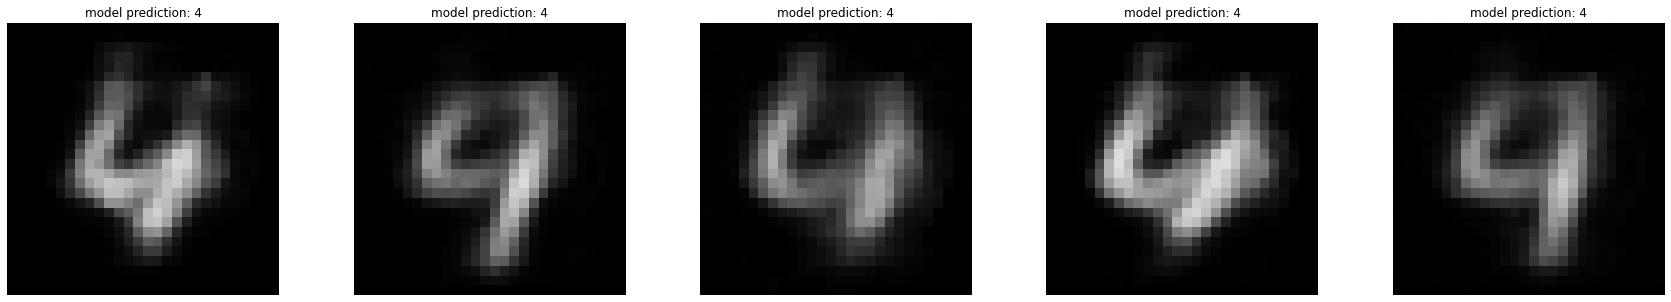

In [4]:
proto = exp.get_prototypes_respecting_rule(num_prototypes=5)

F, ax = plt.subplots(1,5,figsize=(30,5))
for i in range(5):
    ax[i].imshow(proto[i]/255)
    ax[i].axis('off')
    ax[i].set_title('model prediction: '+str(bb_predict(proto[i])[0]))

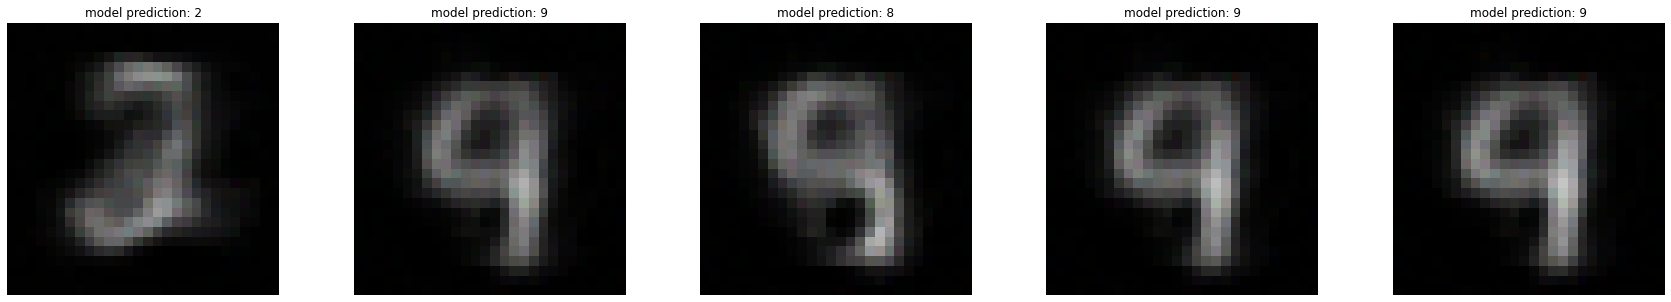

In [5]:
counter = exp.get_counterfactual_prototypes()

F, ax = plt.subplots(1,5,figsize=(30,5))
for i in range(5):
    ax[i].imshow(counter[i]/255)
    ax[i].axis('off')
    ax[i].set_title('model prediction: '+str(bb_predict(counter[i])[0]))